In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications.imagenet_utils import decode_predictions
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
import os

mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images=train_images.reshape(-1,28,28,1)/255.0
test_images=test_images.reshape(-1,28,28,1)/255.0

model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=[28, 28, 1]))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=1)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

loss_object = tf.keras.losses.CategoricalCrossentropy()

Using TensorFlow backend.
W0729 00:31:02.441889 27728 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 00:31:02.477757 27728 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 00:31:02.482739 27728 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 00:31:02.525630 27728 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0729 00:31:02.660265 27728 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\sit

Epoch 1/1
10000/10000 [==============================] - 3s 298us/step
Test accuracy: 0.9863


In [2]:
def create(input_image,input_label):
    size=input_image.shape[0]
    temp=np.zeros((size,10))
    for i in range(temp.shape[0]):
        temp[i,input_label[i]]=1
    prediction=model(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        loss = loss_object(prediction, temp)
  # Get the gradients of the loss w.r.t to the input image.
    gradient = tf.gradients(loss, input_image)
    signed_grad = tf.sign(gradient)
    return tf.reshape(signed_grad,[size,28,28,1])

In [3]:
def ifgsm(eps,alpha,image,image_label,n,temp):
    if n==0:
        return image,temp
    perturbations=create(image,image_label)
    adv_x = image + alpha*perturbations
    temp+=alpha*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    temp=tf.clip_by_value(temp,0,1)
    return ifgsm(eps,alpha,adv_x,image_label,n-1,temp)

In [7]:
epsilons = [0.1,0.1,0.15,0.15]
alpha=[0.01,0.02,0.02,0.03]
result=[]
for (eps,a) in zip(epsilons,alpha):
    tess_acc=0
    for i in range(10):
        test=test_images[1000*i:1000*(i+1),:,:,:]
        bat=test.shape[0]
        images = tf.cast(test, tf.float32)
        images = tf.reshape(images, [bat,28,28,1])
        temp=tf.zeros_like(images)
        adv_x,noise=ifgsm(eps,a,images,test_labels[1000*i:1000*(i+1)],eps//a,temp)  
        adv_pre=model.predict(adv_x, steps=1)
        adv_class=adv_pre.argmax(axis=1)
        adv_con=[x[i] for x,i in zip(adv_pre,adv_class)]
        tess_acc+=model.evaluate(adv_x,test_labels[1000*i:1000*(i+1)],steps=1)[1]
    result.append(tess_acc/10)
for i in range(4):
    print('eps:{},alpha:{},tess_acc:{}'.format(epsilons[i],alpha[i],result[i]))

1/1 [==============================] - 13s 13s/step
eps:0.1,alpha:0.01,tess_acc:0.8421000063419342
eps:0.1,alpha:0.02,tess_acc:0.8462000012397766
eps:0.15,alpha:0.02,tess_acc:0.6714000046253205
eps:0.15,alpha:0.03,tess_acc:0.6234000146389007


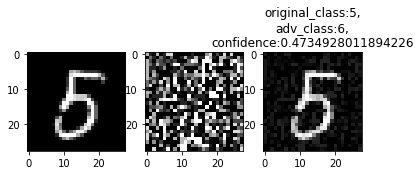

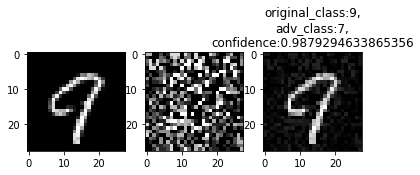

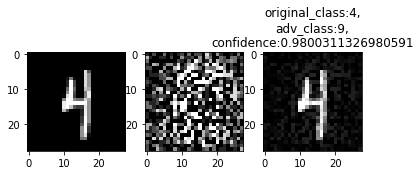

In [13]:
succ_image=adv_class==test_labels[:bat]
u=np.argwhere(succ_image==False).reshape((-1,))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(3):
        f1=plt.figure()
        ax1=f1.add_subplot(131)
        ax2=f1.add_subplot(132)
        ax3=f1.add_subplot(133)
        p=np.random.choice(u)
        ax1.imshow(images[p,:,:,0].eval(),cmap='gray')
        ax2.imshow(noise[p,:,:,0].eval(),cmap='gray')
        ax3.imshow(adv_x[p,:,:,0].eval(),cmap='gray')
        plt.title('original_class:{},\nadv_class:{},\nconfidence:{}'.format(test_labels[p],adv_class[p],adv_con[p]))
        plt.show() 